### Boiler Plate Code

In [27]:
import random
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
%matplotlib inline

In [28]:
# set up params for plots
SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=SMALL)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=SMALL)       # controls default text sizes

##### Iterated Local Search

We closely follow the paper: ILS for QAP (Sultze '05) to implement the below method

In [29]:
class IteratedLocalSearch:
    def __init__(self, w, d):
        self.W = w
        self.D = d
        self.n = w.shape[0]

    def cost(self, X):
        return np.sum(self.W * self.D[X][:, X])
    
    # Subroutines
    def generate_initial_solution(self):
        return np.random.permutation(self.n)
    
    
    def local_search(self, perm: np.array):
        n = len(perm)
        curr_best = np.copy(perm)  # create a deep copy
        
        for i in range(1, n-2):
            for j in range(i+1, n):
                
                new_perm = np.copy(curr_best)
                new_perm[i:j] = curr_best[j-1:i-1:-1]
                
                if self.cost(new_perm) < self.cost(curr_best): 
                    curr_best = new_perm        
        
        return curr_best
    
    
    def acceptance_criterion(self, perm1: np.array, perm2: np.array):
        return perm1 if self.cost(perm1) < self.cost(perm2) else perm2
    
    @staticmethod
    def peturbation(perm: np.array, k: int):
        new_perm = perm[:]
        # of course, this inexact method can result in pertubations of size < k, but these occur with sufficiently small probability 
        for _ in range(k): 
            i = random.randint(0, len(perm)-1)
            j = random.randint(0, len(perm)-1)
            new_perm[i], new_perm[j] = new_perm[j], new_perm[i]   
        
        return new_perm
    

    # ILS implementation
    def iterated_local_search(self, n_iters: int, write_to_file=False):
        s0 = self.generate_initial_solution()
        s  = self.local_search(s0)
        
        curr_best = s
        cost_history = [self.cost(s)]
        perm_history = [s]
        n = len(s0)

        for _ in trange(n_iters):
            s1 = self.peturbation(s, k=n//2)
            s2 = self.local_search(s1)
            curr_best = self.acceptance_criterion(curr_best, s2)
            
            cost_history.append(self.cost(curr_best))
            perm_history.append(curr_best)

        return s, cost_history, perm_history

### Verification

we verify the correctness of our implementation by plotting cost history on the following test instance 

In [30]:
# for managing file opening and closing
def read_integers(filename):
    with open(filename) as f:
        return [int(elem) for elem in f.read().split()]

file_path = '../QAPInstances/tai30b.dat'
file_it = iter(read_integers('../QAPInstances/tai30b.dat'))

# Number of points
n = next(file_it)

# Distance between locations
w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

ils = IteratedLocalSearch(w, d)
soln, cost_hist, perm_hist = ils.iterated_local_search(1_000)

100%|██████████| 1000/1000 [00:15<00:00, 66.44it/s]


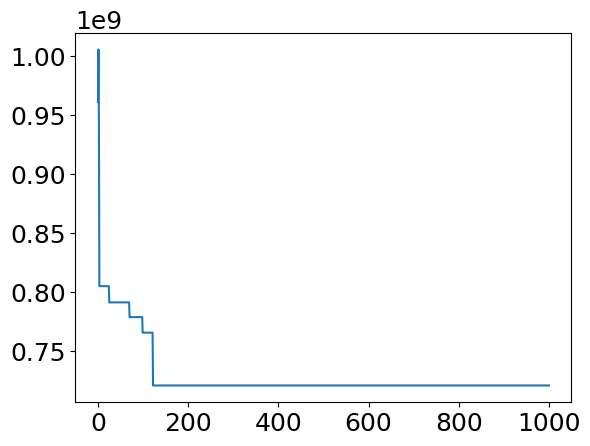

In [31]:
plt.plot(cost_hist)

### Automated Testing
code for automating the opening, closing and testing of a hueristic on every instance in QAPLib

In [34]:
instance_path = '../QAPInstances/'
soln_path     = '../QAPSolns/'

def open_solution(filename: str):
    file_it = iter(read_integers(filename))
    _ = next(file_it)    # this is just how the files within the lib are formatted
    return next(file_it)

        

def test_hueristic(n_iters=10_000, tai_only=False):
    """
    n_iters: number of iterations on each test instance
    tai_only: if True, restricts testing to the Tai instances, reducing computation time
    """
    
    results = [] # for storing results

    for filename in tqdm(os.listdir(instance_path)):
        
        # skips any instances that are not Tai
        if tai_only and 'tai' not in filename: continue  

        file_it = iter(read_integers(instance_path+filename))

        # open QAP instance param's 
        n = next(file_it)
        w = np.array([[next(file_it) for j in range(n)] for i in range(n)])
        d = np.array([[next(file_it) for j in range(n)] for i in range(n)])

        # generate an instance
        ils = IteratedLocalSearch(w, d)

        # open up corresponding soln from QAPLib: 
        soln_file = filename[:-4]+'.sln' # this removes the .dat from filename
        
        try:
            qap_soln = open_solution(soln_path+soln_file)
            huerstic_soln, _, _ = ils.iterated_local_search(n_iters)

            # compute gap
            gap = 100*(ils.cost(huerstic_soln) - qap_soln)/qap_soln
            results.append((soln_file, gap))
            

        # any instances without corresponding solution files are deleted
        except FileNotFoundError:
            os.remove(instance_path+filename) 
    
    # just printing results for now, but will need to save to file or something 
    print(results)

    return

In [35]:
test_hueristic(100, tai_only=True)

100%|██████████| 127/127 [33:34<00:00, 15.86s/it]

[('tai35b.sln', 78.23549542101385), ('tai15a.sln', 25.726017093664833), ('tai35a.sln', 23.588419827894445), ('tai15b.sln', 3.8462488014164244), ('tai80b.sln', 56.383199569316815), ('tai150b.sln', 32.53693050005149), ('tai80a.sln', 16.788451805679514), ('tai100a.sln', 13.888444232613889), ('tai25a.sln', 26.682578628852625), ('tai100b.sln', 51.454035638229065), ('tai25b.sln', 152.8699273889646), ('tai64c.sln', 62.27838579944912), ('tai12a.sln', 45.67588763724512), ('tai12b.sln', 128.34445523461656), ('tai50b.sln', 82.03367912233288), ('tai50a.sln', 18.061122589392234), ('tai30b.sln', 122.17745687832435), ('tai30a.sln', 18.272679971795444), ('tai40a.sln', 19.86124604618124), ('tai17a.sln', 26.549982513643425), ('tai256c.sln', 18.152913671962743), ('tai60b.sln', 79.92105782373483), ('tai40b.sln', 79.81296043517223), ('tai60a.sln', 18.199041293861942), ('tai20a.sln', 27.9901973326965), ('tai20b.sln', 122.77691179751857)]
